# Machine Learning Practical: Coursework 1

**Release date: Monday 10th October 2016**  
**Due date: 16:00 Thursday 27th October 2016**

Instructions for the coursework are [available as a PDF here](http://www.inf.ed.ac.uk/teaching/courses/mlp/2016/coursework_1.pdf).

## Part 1: Learning rate schedules

In [2]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

In [3]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.
import numpy as np
import matplotlib.pyplot as plt
import logging
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit

input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()

* Compare the performance of your time-dependent learning rate schedule when training the standard model on the MNIST digit classiﬁcation task, to training with a constant learning rate baseline.*

In [7]:
def train_model_with_time_dependent_lr(
        free_parameter, model, error, learning_rule, train_data, 
        valid_data, num_epochs, stats_interval):
    
    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    input_dim, output_dim, hidden_dim = 784, 10, 100

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        SigmoidLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        SigmoidLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    error = CrossEntropySoftmaxError()
# Use the created objects to initialise a new Optimiser instance.
    schedulers = [TimeDependentLearningRateScheduler(learning_rate,free_parameter)]
    optimiser = Optimiser(
        model, error, learning_rule, train_data,
        valid_data, data_monitors,schedulers)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
    return stats,keys,run_time

def train_model_with_constant_lr(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    input_dim, output_dim, hidden_dim = 784, 10, 100

    weights_init = GlorotUniformInit(rng=rng)
    biases_init = ConstantInit(0.)

    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
        SigmoidLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
        SigmoidLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    error = CrossEntropySoftmaxError()
    # Use the created objects to initialise a new Optimiser instance.
    schedulers = [ConstantLearningRateScheduler(learning_rate)]
    optimiser = Optimiser(
        model, error, learning_rule, train_data,
        valid_data, data_monitors,schedulers)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
    return stats, keys, run_time
    
def plot_both(stats1,stats2,keys1,run_time1,run_time2):
    
    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(16, 8))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats1.shape[0]) * stats_interval, 
                  stats1[1:, keys1[k]], label= 'time-dependent LR:'+ k)
        ax_1.plot(np.arange(1, stats1.shape[0]) * stats_interval, 
                   stats2[1:, keys1[k]], label='constant LR:' + k, linestyle='-.')
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    ax_1.set_ylabel('Error')
    fig_1.savefig('error_train_valid.pdf')
    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(16, 8))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats1.shape[0]) * stats_interval, 
                  stats1[1:, keys1[k]], label= 'time-dependent LR:'+ k)
        ax_2.plot(np.arange(1, stats1.shape[0]) * stats_interval, 
                   stats2[1:, keys1[k]], label='constant LR:' + k, linestyle='-.')
                  
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    ax_2.set_ylabel('Accuracy')
    fig_2.savefig('acc_train_valid.pdf')
   
    return stats1,stats2,keys1, keys2, run_time1,run_time2, fig_1, ax_1, fig_2, ax_2


Epoch 5: 0.90s to complete
    error(train)=2.52e-01, acc(train)=9.27e-01, error(valid)=2.39e-01, acc(valid)=9.29e-01
Epoch 10: 0.91s to complete
    error(train)=1.71e-01, acc(train)=9.51e-01, error(valid)=1.70e-01, acc(valid)=9.53e-01
Epoch 5: 0.91s to complete
    error(train)=2.76e-01, acc(train)=9.19e-01, error(valid)=2.60e-01, acc(valid)=9.25e-01
Epoch 10: 0.88s to complete
    error(train)=2.18e-01, acc(train)=9.36e-01, error(valid)=2.09e-01, acc(valid)=9.39e-01


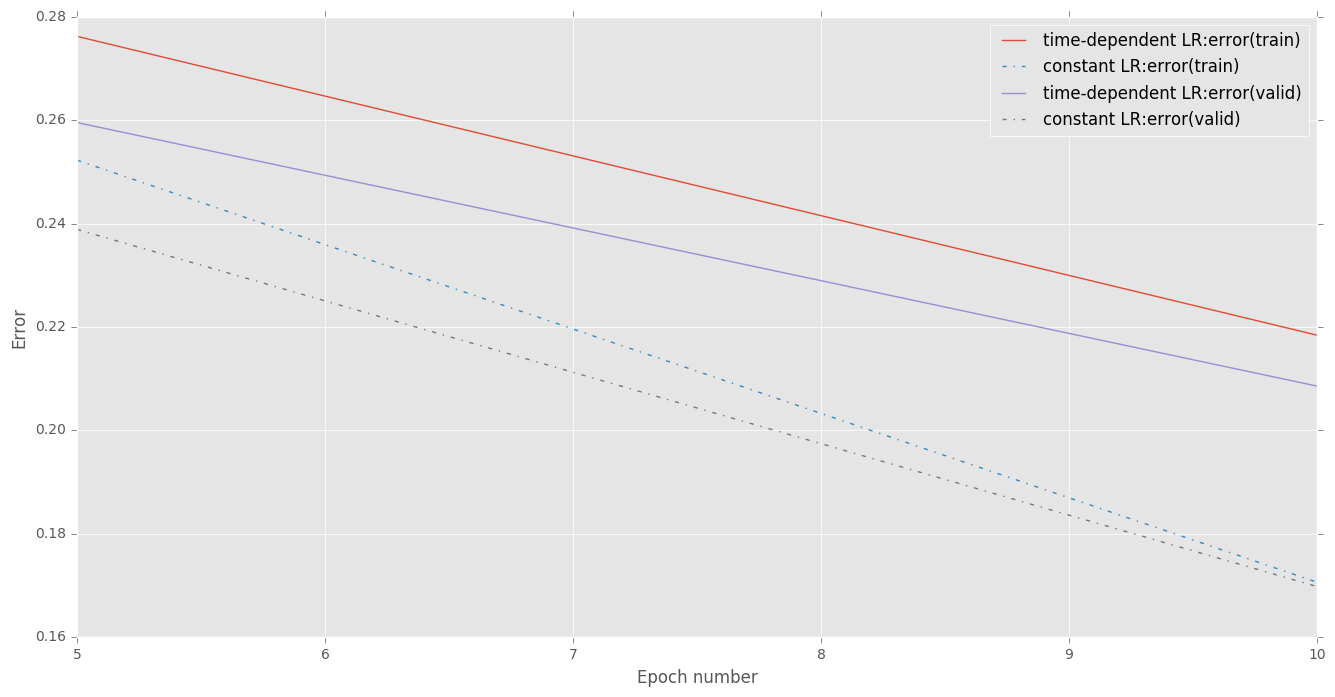

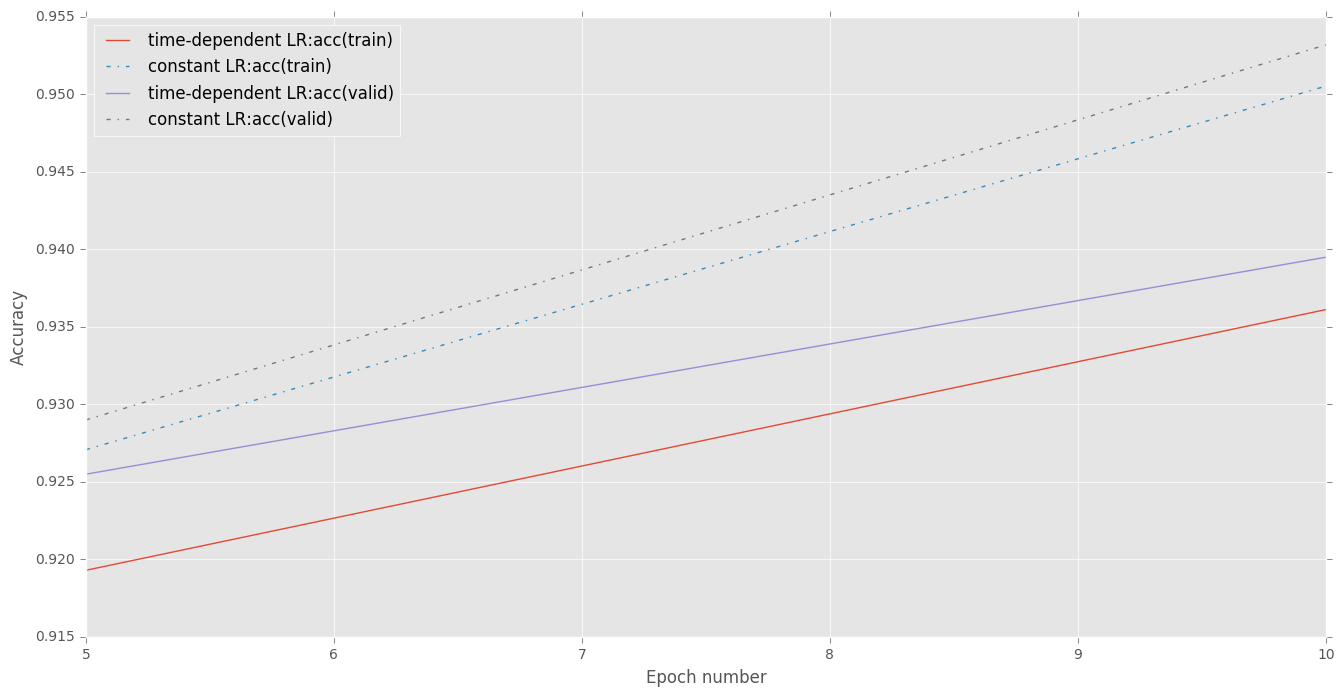

In [24]:
from mlp.learning_rules import GradientDescentLearningRule
from mlp.schedulers import TimeDependentLearningRateScheduler
from mlp.schedulers import ConstantLearningRateScheduler
from mlp.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')
batch_size = 50  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # initial learning rate for gradient descent
num_epochs = 10 # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
free_parameter = 10 # parameter governing how quickly the learning rate decays. 
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results

learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

rng.seed(seed)
train_data.reset()
valid_data.reset()

stats2, keys2, run_time2 = train_model_with_constant_lr(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

stats1, keys1, run_time1 = train_model_with_time_dependent_lr(
    free_parameter, model, error, learning_rule, train_data, 
    valid_data, num_epochs, stats_interval)


_ = plot_both(stats1,stats2,keys1,run_time1,run_time2)

*Answer:* First, for the model using time-dependent linear rate, the performance of the validation data is better than that of training data with the initial learning rate of 0.1 and the free parameter of 10. However, the performance of the validation data is worser for the model using constant learning rate. 
Second, the overall performance of the time-dependent learning rate set is not as good as that of the constant learning rate. 

*Indicate how the free schedule parameters η0 and r affect the evolution of the training.*

1


Epoch 5: 0.90s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 10: 1.04s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 15: 1.62s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 20: 1.16s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 25: 1.33s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 30: 0.95s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 35: 0.91s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 40: 0.90s to complete
    error(train)=5.74e-01, acc(train)=8.38e-01, error(valid)=5.39e-01, acc(valid)=8.53e-01
Epoch 45: 0.96s to complete
    error(train)=5.74

2


Epoch 5: 0.90s to complete
    error(train)=4.06e-01, acc(train)=8.89e-01, error(valid)=3.76e-01, acc(valid)=8.98e-01
Epoch 10: 0.99s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 15: 1.08s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 20: 0.91s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 25: 1.25s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 30: 0.92s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 35: 0.96s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 40: 0.98s to complete
    error(train)=4.05e-01, acc(train)=8.89e-01, error(valid)=3.75e-01, acc(valid)=8.98e-01
Epoch 45: 0.95s to complete
    error(train)=4.05

3


Epoch 5: 0.99s to complete
    error(train)=2.78e-01, acc(train)=9.19e-01, error(valid)=2.60e-01, acc(valid)=9.24e-01
Epoch 10: 1.03s to complete
    error(train)=2.19e-01, acc(train)=9.36e-01, error(valid)=2.09e-01, acc(valid)=9.41e-01
Epoch 15: 0.96s to complete
    error(train)=1.92e-01, acc(train)=9.44e-01, error(valid)=1.87e-01, acc(valid)=9.49e-01
Epoch 20: 0.93s to complete
    error(train)=1.79e-01, acc(train)=9.48e-01, error(valid)=1.76e-01, acc(valid)=9.52e-01
Epoch 25: 0.95s to complete
    error(train)=1.72e-01, acc(train)=9.50e-01, error(valid)=1.70e-01, acc(valid)=9.54e-01
Epoch 30: 1.00s to complete
    error(train)=1.67e-01, acc(train)=9.51e-01, error(valid)=1.67e-01, acc(valid)=9.55e-01
Epoch 35: 1.00s to complete
    error(train)=1.65e-01, acc(train)=9.52e-01, error(valid)=1.64e-01, acc(valid)=9.56e-01
Epoch 40: 1.24s to complete
    error(train)=1.63e-01, acc(train)=9.53e-01, error(valid)=1.63e-01, acc(valid)=9.56e-01
Epoch 45: 1.23s to complete
    error(train)=1.62

4


Epoch 5: 0.92s to complete
    error(train)=2.60e-01, acc(train)=9.24e-01, error(valid)=2.45e-01, acc(valid)=9.29e-01
Epoch 10: 0.91s to complete
    error(train)=1.80e-01, acc(train)=9.47e-01, error(valid)=1.77e-01, acc(valid)=9.51e-01
Epoch 15: 2.25s to complete
    error(train)=1.32e-01, acc(train)=9.61e-01, error(valid)=1.39e-01, acc(valid)=9.62e-01
Epoch 20: 1.37s to complete
    error(train)=1.05e-01, acc(train)=9.69e-01, error(valid)=1.22e-01, acc(valid)=9.67e-01
Epoch 25: 1.16s to complete
    error(train)=8.65e-02, acc(train)=9.75e-01, error(valid)=1.10e-01, acc(valid)=9.70e-01
Epoch 30: 0.98s to complete
    error(train)=7.63e-02, acc(train)=9.78e-01, error(valid)=1.07e-01, acc(valid)=9.71e-01
Epoch 35: 0.90s to complete
    error(train)=6.09e-02, acc(train)=9.84e-01, error(valid)=9.77e-02, acc(valid)=9.72e-01
Epoch 40: 1.00s to complete
    error(train)=5.15e-02, acc(train)=9.87e-01, error(valid)=9.22e-02, acc(valid)=9.75e-01
Epoch 45: 0.97s to complete
    error(train)=4.54

5


Epoch 5: 0.92s to complete
    error(train)=2.59e-01, acc(train)=9.25e-01, error(valid)=2.42e-01, acc(valid)=9.28e-01
Epoch 10: 0.89s to complete
    error(train)=1.73e-01, acc(train)=9.49e-01, error(valid)=1.68e-01, acc(valid)=9.54e-01
Epoch 15: 0.91s to complete
    error(train)=1.26e-01, acc(train)=9.63e-01, error(valid)=1.33e-01, acc(valid)=9.63e-01
Epoch 20: 0.90s to complete
    error(train)=9.60e-02, acc(train)=9.72e-01, error(valid)=1.14e-01, acc(valid)=9.67e-01
Epoch 25: 0.90s to complete
    error(train)=7.70e-02, acc(train)=9.78e-01, error(valid)=1.03e-01, acc(valid)=9.71e-01
Epoch 30: 0.90s to complete
    error(train)=6.31e-02, acc(train)=9.83e-01, error(valid)=9.62e-02, acc(valid)=9.72e-01
Epoch 35: 0.90s to complete
    error(train)=5.12e-02, acc(train)=9.86e-01, error(valid)=9.12e-02, acc(valid)=9.73e-01
Epoch 40: 0.90s to complete
    error(train)=4.10e-02, acc(train)=9.90e-01, error(valid)=8.49e-02, acc(valid)=9.75e-01
Epoch 45: 1.05s to complete
    error(train)=3.33

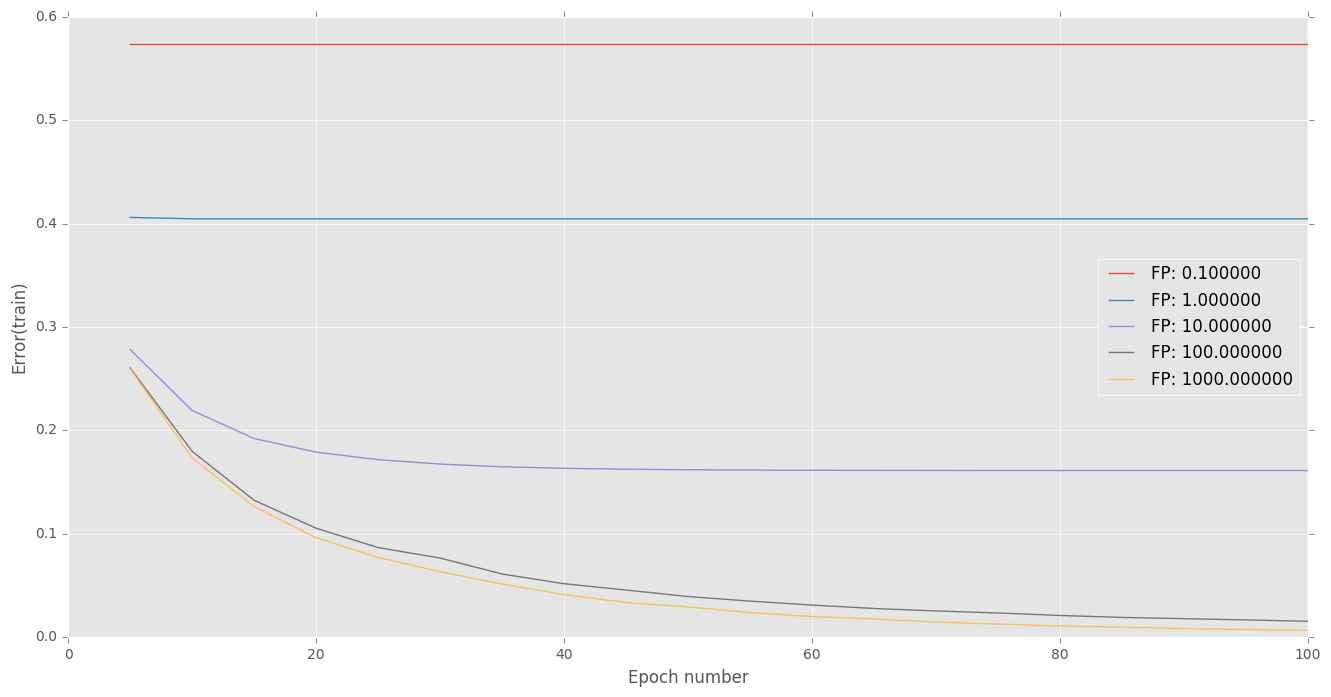

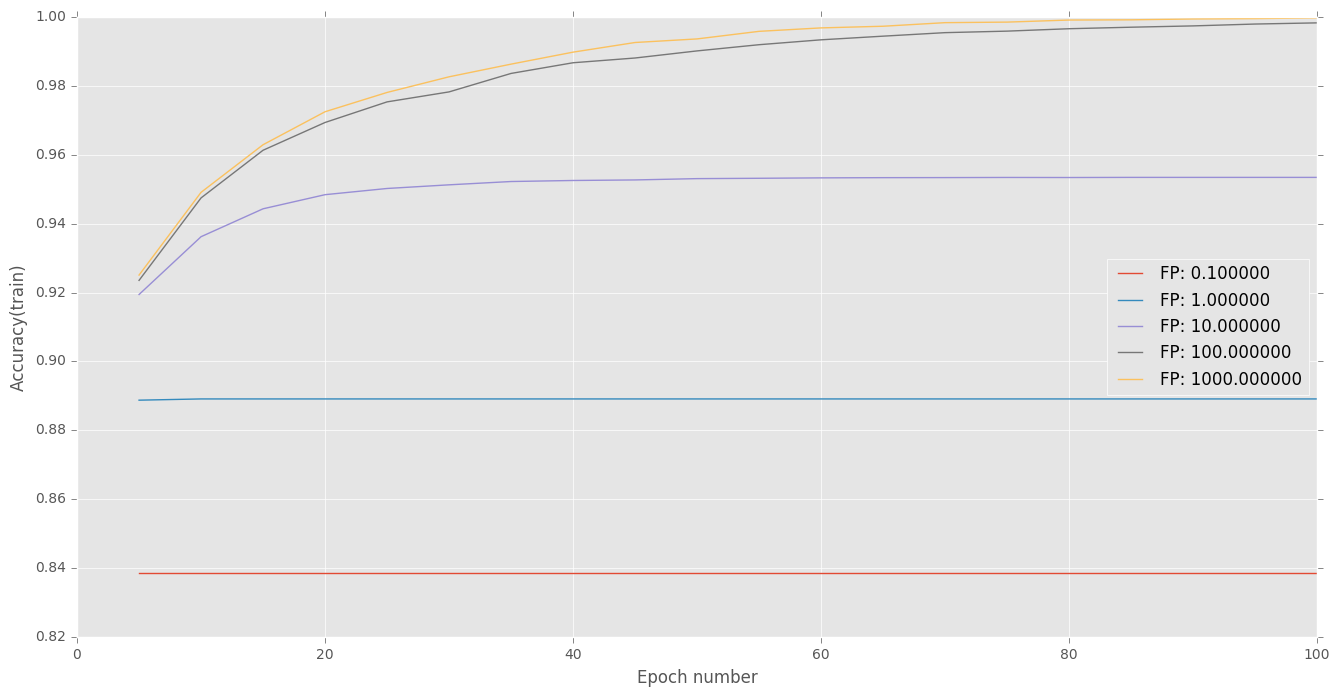

In [15]:
from mlp.learning_rules import GradientDescentLearningRule
from mlp.schedulers import TimeDependentLearningRateScheduler
from mlp.schedulers import ConstantLearningRateScheduler
from mlp.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')
batch_size = 50  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # initial learning rate for gradient descent
num_epochs = 100 # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
free_parameter = np.array([0.1,1.,10.,100.,1000.])  # parameter governing how quickly the learning rate decays. 
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results

learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

rng.seed(seed)
train_data.reset()
valid_data.reset()

# for  in free_parameter:
#     stats = np.zeros(np.size(free_parameter))
#     stats[i], keys, run_time[i] = train_model_with_time_dependent_lr(
#     k, model, error, learning_rule, train_data, 
#     valid_data, num_epochs, stats_interval)
#     i=i+1
# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(16, 8))
ax_1 = fig_1.add_subplot(111)
fig_2 = plt.figure(figsize=(16, 8))
ax_2 = fig_2.add_subplot(111)
k1 = 'error(train)'
k2 = 'acc(train)'
for i in np.arange(1,np.size(free_parameter)+1):
    print i
    stats, keys, run_time = train_model_with_time_dependent_lr(
    free_parameter[i-1], model, error, learning_rule, train_data, 
    valid_data, num_epochs, stats_interval)
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
            stats[1:, keys[k1]], label= 'FP: ' + '%f' %free_parameter[i-1])

#               stats[1:, keys[k]], label= k + '%d' % free_parameter[i-1])      
#     for k in ['error(train)', 'acc(train)']:
#         ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#               stats[1:, keys[k]], label= k + '%f' % free_parameter[i-1])
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k2]], label= 'FP: ' + '%f' %free_parameter[i-1])

ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')
ax_1.set_ylabel('Error(train)')
fig_1.savefig("error_in_train_free_parameter.pdf")

ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
ax_2.set_ylabel('Accuracy(train)')
fig_2.savefig("accuracy_in_train_free_parameter.pdf")



1


Epoch 5: 1.32s to complete
    error(train)=1.02e+00, acc(train)=7.41e-01, error(valid)=9.90e-01, acc(valid)=7.69e-01
Epoch 10: 1.09s to complete
    error(train)=5.84e-01, acc(train)=8.45e-01, error(valid)=5.48e-01, acc(valid)=8.61e-01
Epoch 15: 0.89s to complete
    error(train)=4.46e-01, acc(train)=8.81e-01, error(valid)=4.15e-01, acc(valid)=8.89e-01
Epoch 20: 0.89s to complete
    error(train)=3.83e-01, acc(train)=8.95e-01, error(valid)=3.57e-01, acc(valid)=9.01e-01
Epoch 25: 0.89s to complete
    error(train)=3.50e-01, acc(train)=9.02e-01, error(valid)=3.26e-01, acc(valid)=9.07e-01
Epoch 30: 0.89s to complete
    error(train)=3.28e-01, acc(train)=9.07e-01, error(valid)=3.06e-01, acc(valid)=9.14e-01
Epoch 35: 0.89s to complete
    error(train)=3.11e-01, acc(train)=9.12e-01, error(valid)=2.91e-01, acc(valid)=9.18e-01
Epoch 40: 0.89s to complete
    error(train)=2.98e-01, acc(train)=9.15e-01, error(valid)=2.78e-01, acc(valid)=9.21e-01
Epoch 45: 0.89s to complete
    error(train)=2.86

2


Epoch 5: 0.90s to complete
    error(train)=2.60e-01, acc(train)=9.24e-01, error(valid)=2.44e-01, acc(valid)=9.30e-01
Epoch 10: 1.12s to complete
    error(train)=1.75e-01, acc(train)=9.50e-01, error(valid)=1.70e-01, acc(valid)=9.54e-01
Epoch 15: 1.43s to complete
    error(train)=1.30e-01, acc(train)=9.62e-01, error(valid)=1.38e-01, acc(valid)=9.62e-01
Epoch 20: 1.00s to complete
    error(train)=1.03e-01, acc(train)=9.70e-01, error(valid)=1.19e-01, acc(valid)=9.66e-01
Epoch 25: 1.95s to complete
    error(train)=8.57e-02, acc(train)=9.76e-01, error(valid)=1.09e-01, acc(valid)=9.69e-01
Epoch 30: 0.90s to complete
    error(train)=6.95e-02, acc(train)=9.81e-01, error(valid)=9.84e-02, acc(valid)=9.72e-01
Epoch 35: 0.90s to complete
    error(train)=5.86e-02, acc(train)=9.84e-01, error(valid)=9.38e-02, acc(valid)=9.73e-01
Epoch 40: 0.90s to complete
    error(train)=5.09e-02, acc(train)=9.86e-01, error(valid)=9.03e-02, acc(valid)=9.73e-01
Epoch 45: 0.90s to complete
    error(train)=4.35

3


Epoch 5: 0.89s to complete
    error(train)=6.05e-02, acc(train)=9.82e-01, error(valid)=9.38e-02, acc(valid)=9.71e-01
Epoch 10: 1.15s to complete
    error(train)=2.14e-02, acc(train)=9.94e-01, error(valid)=8.17e-02, acc(valid)=9.77e-01
Epoch 15: 0.89s to complete
    error(train)=6.57e-03, acc(train)=9.99e-01, error(valid)=8.33e-02, acc(valid)=9.78e-01
Epoch 20: 0.89s to complete
    error(train)=2.87e-03, acc(train)=1.00e+00, error(valid)=8.93e-02, acc(valid)=9.79e-01
Epoch 25: 0.95s to complete
    error(train)=1.62e-03, acc(train)=1.00e+00, error(valid)=9.01e-02, acc(valid)=9.80e-01
Epoch 30: 0.97s to complete
    error(train)=1.04e-03, acc(train)=1.00e+00, error(valid)=9.36e-02, acc(valid)=9.80e-01
Epoch 35: 0.99s to complete
    error(train)=8.28e-04, acc(train)=1.00e+00, error(valid)=9.51e-02, acc(valid)=9.80e-01
Epoch 40: 0.90s to complete
    error(train)=6.85e-04, acc(train)=1.00e+00, error(valid)=9.63e-02, acc(valid)=9.79e-01
Epoch 45: 0.89s to complete
    error(train)=5.79

4


Epoch 5: 1.41s to complete
    error(train)=6.64e+00, acc(train)=1.02e-01, error(valid)=6.66e+00, acc(valid)=1.03e-01
Epoch 10: 0.86s to complete
    error(train)=5.15e+00, acc(train)=1.04e-01, error(valid)=5.12e+00, acc(valid)=1.09e-01
Epoch 15: 1.04s to complete
    error(train)=5.77e+00, acc(train)=9.94e-02, error(valid)=5.71e+00, acc(valid)=9.90e-02
Epoch 20: 1.21s to complete
    error(train)=5.79e+00, acc(train)=1.04e-01, error(valid)=5.73e+00, acc(valid)=1.09e-01
Epoch 25: 0.86s to complete
    error(train)=4.71e+00, acc(train)=9.86e-02, error(valid)=4.65e+00, acc(valid)=9.91e-02
Epoch 30: 0.86s to complete
    error(train)=4.36e+00, acc(train)=9.90e-02, error(valid)=4.39e+00, acc(valid)=9.67e-02
Epoch 35: 1.98s to complete
    error(train)=3.17e+00, acc(train)=9.98e-02, error(valid)=3.18e+00, acc(valid)=9.61e-02
Epoch 40: 1.23s to complete
    error(train)=3.01e+00, acc(train)=9.72e-02, error(valid)=3.00e+00, acc(valid)=9.83e-02
Epoch 45: 1.15s to complete
    error(train)=2.99

5


Epoch 5: 0.78s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 10: 0.79s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 15: 0.79s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 20: 0.79s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 25: 0.80s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 30: 0.79s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 35: 0.80s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 40: 0.79s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 45: 0.79s to complete
    error(train)=nan, acc(train)=9.86e-02, error(valid)=nan, acc(valid)=9.91e-02
Epoch 50: 0.80s to c

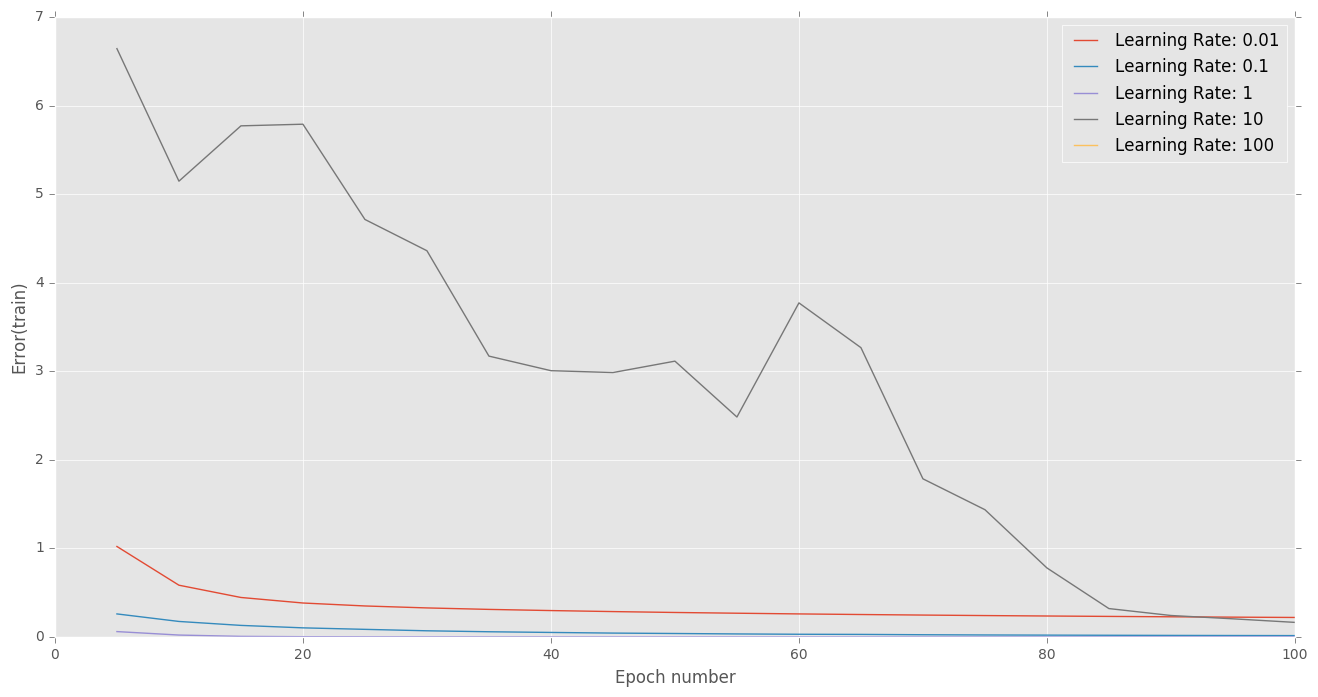

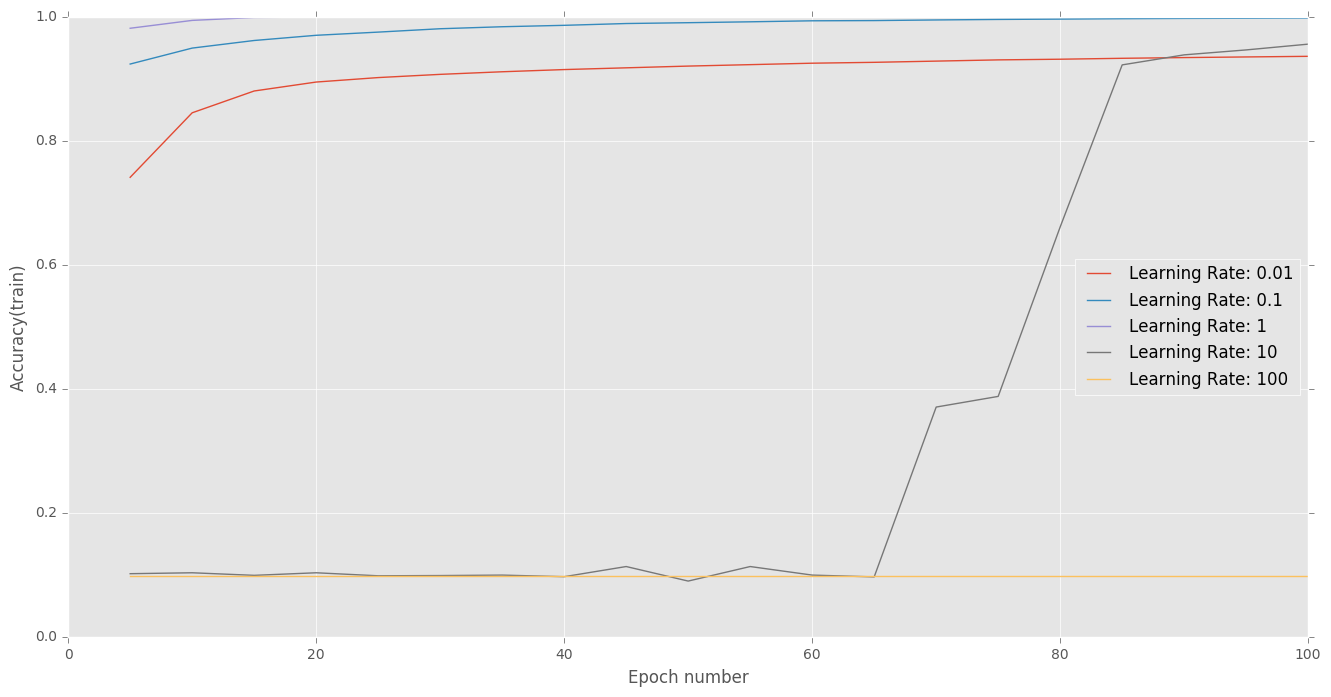

In [23]:
from mlp.learning_rules import GradientDescentLearningRule
from mlp.schedulers import TimeDependentLearningRateScheduler
from mlp.schedulers import ConstantLearningRateScheduler
from mlp.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')
batch_size = 50  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation

lr = [0.01,0.1,1.0,10,100]  # initial learning rate for gradient descent

num_epochs = 100 # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
free_parameter = 100  # parameter governing how quickly the learning rate decays. 
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results


rng.seed(seed)
train_data.reset()
valid_data.reset()

# for  in free_parameter:
#     stats = np.zeros(np.size(free_parameter))
#     stats[i], keys, run_time[i] = train_model_with_time_dependent_lr(
#     k, model, error, learning_rule, train_data, 
#     valid_data, num_epochs, stats_interval)
#     i=i+1
# Plot the change in the validation and training set error over training.
fig_1 = plt.figure(figsize=(16, 8))
ax_1 = fig_1.add_subplot(111)
fig_2 = plt.figure(figsize=(16, 8))
ax_2 = fig_2.add_subplot(111)
k1 = 'error(train)'
k2 = 'acc(train)'

for i in np.arange(1,np.size(lr)+1):
    print i
    learning_rate = lr[i-1]
    learning_rule = GradientDescentLearningRule(learning_rate = learning_rate)
    stats, keys, run_time = train_model_with_time_dependent_lr(
    free_parameter, model, error, learning_rule, train_data, 
    valid_data, num_epochs, stats_interval)
#     for k in ['acc(train)', 'acc(valid)']:
#         if k == 'acc(train)':
#             ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#               stats[1:, keys[k]], label= k +'Learning Rate: %g' %learning_rate)
#         else:
#             ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#               stats[1:, keys[k]], label= k +'Learning Rate: %g' %learning_rate,linestyle='--')

#               stats[1:, keys[k]], label= k + '%d' % free_parameter[i-1])      
#     for k in ['error(train)', 'error(valid)']:
#         ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#               stats[1:, keys[k]], label= k + '%d' % free_parameter[i-1])  

    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k1]], label= 'Learning Rate: %g' %learning_rate)
    ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k2]], label= 'Learning Rate: %g' %learning_rate)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')
ax_1.set_ylabel('Error(train)')
fig_1.savefig('LR_comparison_err.pdf')

ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
ax_2.set_ylabel('Accuracy(train)')
fig_2.savefig('LR_comparison_acc.pdf')

## Part 2: Momentum learning rule

In [ ]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

In [38]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit

input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()

*First Task >> Compare the performance of a basic gradient descent learning rule to the momentum learning rule for several values of the momentum coeﬃcient α.*

## Part 3: Adaptive learning rules

In [ ]:
# The below code will set up the data providers, random number
# generator and logger objects needed for training runs. As
# loading the data from file take a little while you generally
# will probably not want to reload the data providers on
# every training run. If you wish to reset their state you
# should instead use the .reset() method of the data providers.
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

In [ ]:
# The model set up code below is provided as a starting point.
# You will probably want to add further code cells for the
# different experiments you run.

from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit

input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()